<a href="https://colab.research.google.com/github/taomasgonzalez/Electrocardiogram-LMS/blob/master/Electrocardiogram_anomalies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectando anomalías en Electrocardiogramas (ECG)

## Imports

Instalamos las librerías necesarias

In [125]:
!pip install wfdb
!pip install padasip

Importamos las librerías necesarias

In [0]:
# https://github.com/MIT-LCP/wfdb-python
# https://wfdb.readthedocs.io/en/latest/
import numpy as np
import wfdb
import matplotlib.pyplot as plt
import padasip as pa

Clonamos el repositorio de github:

In [127]:
!git clone "https://github.com/taomasgonzalez/Electrocardiogram-LMS.git"

fatal: destination path 'Electrocardiogram-LMS' already exists and is not an empty directory.


## Obtención de los datos

Obtenemos los datos de electrocardiogramas realizados a múltiples pacientes del MIT-BIH Arrhythmia Database (https://physionet.org/content/mitdb/1.0.0/).

Para más información sobre su contenido y las particularidades con las que los datos fueron obtenidos, visitar la página.

### Definición de funciones de obtención de datos del dataset

In [0]:
def get_data(file_path, sampto='end'):
  """
  get_data devuelve las señales del primer y segundo canal de un archivo que cumple con el estándar wfdb,
  la metadata del mismo y las anotaciones del mismo en caso de haberlas (archivo con el mismo nombre pero con extensión .atr)
  
  Parámetros:
    file_path: path del archivo de donde conseguir las señales a leer.
    sampto: cantidad de samples a leer. Si 'end', lee todas las samples del archivo.
  Returns:
    signal_0: Señal del primer canal.
    signal_1: Señal del segundo canal.
    metadata: metadata que contiene, entre otras cosas, la sample frequency utilizada para tomar los datos.
    annotation: anotaciones correspondientes al archivo
  """
  # Cada columna de la matriz signals es un canal de las señales grabadas del paciente(signals[0] es el primer canal)
  # metadata tiene información como la sample frequency, importante para el resto del trabajo.
  signals, metadata = wfdb.rdsamp(record_name=file_path, sampto=sampto)
  annotation = wfdb.rdann(record_name=file_path, extension='atr', sampto=sampto)
  
  return signals[:,0], signals[:,1], metadata, annotation

### Obtención de las señales

Definimos que archivos obtendremos están presentes en dataset, quer serán los archivos que extraeremos

In [0]:
all_signals = {str(i): dict() for j in (range(100, 125), range(200, 224)) for i in j}
# borramos del dictionary a los archivos que no estan pero que fueron agregados por comodidad
for i in ['110', '120', '204','206','211','216','218']: del all_signals[i]   
all_signals['228'] = None
for i in range(230,235) : all_signals[str(i)] = None

Obtenemos las señales de cada canal, en conjunto con su metadata y las anotaciones que corresponden a la presencia de anomalía o no.

In [0]:
for signal_name in all_signals.keys():
  upper_signal, lower_signal, metadata, annotations =  get_data(file_path='/content/Electrocardiogram-LMS/data/' + signal_name,sampto=None)
  all_signals[signal_name] = {'upper' : upper_signal, 'lower' : lower_signal, 'meta':metadata, 'annot': annotations} 

Visualizamos alguna de las señales:

Hacemos un plot de los primeros 1000 samples de una de las señales de uno de los pacientes

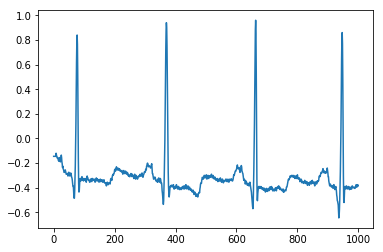

In [131]:
plt.plot(all_signals[list(all_signals.keys())[0]]['upper'][:1000])

### Anotaciones

Visualizamos la clase anotaciones, cómo está estructurada internamente.


In [132]:
anot = all_signals[list(all_signals.keys())[0]]['annot']
attsr = vars(anot)
print ('\n'.join("%s: %s" % item for item in attrs.items()))

record_name: 100
extension: atr
sample: [    18     77    370 ... 649484 649734 649991]
symbol: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A']
subtype: [0 0 0 ... 0 0 0]
chan: [0 0 0 ... 0 0 0]
num: [0 0 0 ... 0 0 0]
aux_note: ['(N\x00', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '

Cambiamos todas las anotaciones a un formato binario de tipo "anómala" ('A') o "no anómala" ('N'). 
Visualizamos luego el resultado de un fragmento de una señal de un paciente.

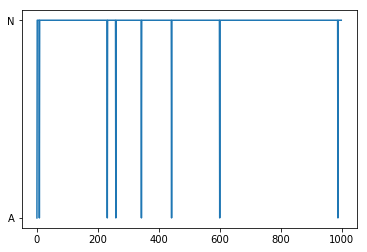

In [133]:
for key in all_signals.keys():
  anot = all_signals[key]['annot']
  anot.symbol = ['A' if i is not 'N' else 'N' for i in anot.symbol]

anot = all_signals[list(all_signals.keys())[0]]['annot']
plt.plot(anot.symbol[0:1000])

## Implementación del filtro adaptativo

In [0]:
# https://matousc89.github.io/padasip/sources/filters/lms.html#references
# https://matousc89.github.io/padasip/_modules/padasip/filters/lms.html#FilterLMS
def lms_predictor(input_signal, desired_response, filter_size, mu=0.1, initial_w):  
  lms_filter = pa.filters.FilterLMS(n=filter_size, mu=mu, w=initial_w)
  y, e, w = lms_filter.run(d=desired_response, x=input_signal)
  return y ,e ,w   

## Implementación del detector de anomalías

### Implementación del detector

In [0]:
def detect_anomalies(input_signal):
  anomalies_times = []  # numero de samples en los que se detecta una anomalía
#   y ,e ,w = lms_predictor(input_signal, desired_response, filter_size, mu=0.1, initial_w)
  # hay que detectar una cota del error o la derivada o algun criterio que nos permita saber si la señal es anomala
  return anomalies_times

### Cálculo de performance del detector

In [0]:
def check_detector_performance(real_anomalies, detected_anomalies):
  pass

## Probando al detector

## Resultados